# Analysis for fires in Sentinel-1 images


In [2]:
import numpy as np
import sys
#Folder with my own functions(my_s1, my_s3 and my_modis)
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\code')
#Folder where im fetching the data from
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\data\\s1')
#my functions
import my_s1 as s1
import my_modis as md
import my_tools as tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage

def s1_plot_hist(images):
    """
    """
    
    for i in range(len(images)):
        img_cfar = images[i][(images[i]>np.quantile(images[i], 0.01)) &  (images[0]<np.quantile(images[i], 0.99))]
        #Plotting 
        hist_cfar,bins_cfar = np.histogram((img_cfar).ravel(),bins=51)
        width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
        center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
        plt.bar(center_cfar, hist_cfar, align='center', width=width_cfar)
        plt.title('Historgram')
        plt.xlabel("Intensity", fontsize=16)  
        plt.ylabel("Amout of pixels", fontsize=16)
        plt.xticks(fontsize=14)  
        plt.yticks(fontsize=14)

    plt.show()
    return None


from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N



from collections import deque
from bisect import insort, bisect_left
from itertools import islice
def running_median(img, size):
    """Contributed by Peter Otten"""
    img = iter(img)
    d = deque()
    s = []
    result = []
    for item in islice(img, size):
        d.append(item)
        insort(s, item)
        result.append(s[len(d)//2])
    m = size // 2
    for item in img:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        result.append(s[m])
    return result

### Loading image

Firstly loading an image. The image loaded is taken from the Sentinel-1 satellite on 23th of July 2018 above the area of Ljusdal where the largest wildfire of 2018 happend.




### Displaying images

In [70]:
#the folder where the s1 images are located.
folder_path = "C:\\Users\\krist\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6"
#getting all files with extention .tif.\
img_paths = s1.file_paths(folder_path,verbose=1,file_type='tif')
#17th
folder_path2 = "C:\\Users\\krist\\Desktop\\til_inge"
img_paths2 = s1.file_paths(folder_path2,verbose=1,file_type='tif')


there are: 9  . tif  files in folder

there are: 3  . tif  files in folder


In [71]:
img_paths2

['C:\\Users\\krist\\Desktop\\til_inge\\17juli\\subset_6_of_subset_4_of_S1B_IW_GRDH_1SDV_20180717T162913_20180717T162938_011853_015D13_74EC_Cal_Spk_TC.tif',
 'C:\\Users\\krist\\Desktop\\til_inge\\17juli\\subset_6_of_subset_4_of_S1B_IW_GRDH_1SDV_20180717T162913_20180717T162938_011853_015D13_74EC_Cal_TC.tif',
 'C:\\Users\\krist\\Desktop\\til_inge\\17juli\\subset_6_of_subset_4_of_S1B_IW_GRDH_1SDV_20180717T162913_20180717T162938_011853_015D13_74EC_Cal_TC_2_noise_removal_dB_tif.tif']

In [72]:
img_paths

['C:\\Users\\krist\\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6\\collocate_06_04.tif',
 'C:\\Users\\krist\\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6\\collocate_06_28.tif',
 'C:\\Users\\krist\\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6\\collocate_07_10.tif',
 'C:\\Users\\krist\\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6\\collocate_17_07.tif',
 'C:\\Users\\krist\\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6\\collocate_dB_23_07.tif',
 'C:\\Users\\krist\\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6\\collocate_dB_23_07_no_dB.tif',
 'C:\\Users\\krist\\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6\\subset_1_of_collocate_07_10.tif',
 'C:\\Users\\krist\\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6\\subset_2_of_collocate_06_28.tif',
 'C:\\Users\\krist\\Documents\\Syntese\\data\\s1\\ljusdal\\before_fire\\done\\16_6\\subset_3_of_collocate_06_04.tif'

Alright. As we can see, there are images from the 4th, 28th and 10th.

In [73]:
images,raster,extend, names, extra = s1.get_img([img_paths[6],img_paths[7],img_paths[8],img_paths[5]],data_type='ENVI')
#images,raster,extend, names, extra = s1.get_img([img_paths[0]],data_type='ENVI')
images_17,raster_17,extend_17, names_17, extra_17 = s1.get_img([img_paths2[-1]],data_type='ENVI')

images loading

4 images are being loaded
imgage 1
There are 2 bands
imgage 2
There are 2 bands
imgage 3
There are 2 bands
imgage 4
There are 2 bands
images loading

1 images are being loaded
imgage 1
There are 4 bands


1st band is Vh, second is VV and the last is a mask of flags (not useful here)

In [8]:
len(images)

8

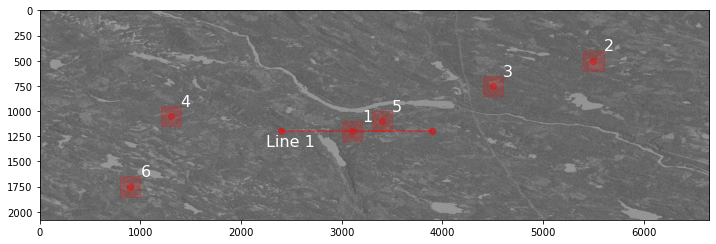

In [74]:
centroids_analysis_s1 = []
centroids_analysis_s1.append([3100,1200])
centroids_analysis_s1.append([5500,500])
centroids_analysis_s1.append([4500,750])
centroids_analysis_s1.append([1300,1050])
centroids_analysis_s1.append([3400,1100])
centroids_analysis_s1.append([900,1750])
name = 'several_boxes.png'
#img= lee_filter(images[1],5)
img  =images[0]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axes.imshow(img,cmap='binary')
#-- Extract the line...
x0_2, y0_2 = 2400, 1200 # These are in _pixel_ coordinates!!
x1_2, y1_2 = 3900, 1200
num = x1_2-x0_2
x_2, y_2 = np.linspace(x0_2, x1_2, num), np.linspace(y0_2, y1_2, num)
zi_vh_2 = scipy.ndimage.map_coordinates(images[1], np.vstack((y_2,x_2)))
zi_vv_2 = scipy.ndimage.map_coordinates(images[3], np.vstack((y_2,x_2)))
axes.annotate('Line 1', (x0_2-150, y0_2+150),color='white', size=16)

for i in range(len(centroids_analysis_s1)):
    rect = plt.Rectangle((centroids_analysis_s1[i][0]-100,centroids_analysis_s1[i][1]-100), 200, 200,color='red', alpha=0.2)
    axes.add_patch(rect)
    axes.scatter(centroids_analysis_s1[i][0],centroids_analysis_s1[i][1], alpha=0.4, color='r')
    axes.annotate(str(i+1), (centroids_analysis_s1[i][0]+100, centroids_analysis_s1[i][1]-100),color='white', size=16)
    
plt.plot([x0_2, x1_2], [y0_2, y1_2], 'ro-', alpha=0.5)


#plt.savefig(name, bbox_inches='tight', dpi=600)
plt.show()



Especially the historgram made by the second line, atop of box 1, is bearly visible in the S2 image. 
If this was able to be somewhat detected using s1, we are golden.

## average

In [84]:
pre_fire_vv = np.average(np.dstack((images[1],images[3],images[5])), axis=-1)
pre_fire_vh = np.average(np.dstack((images[0],images[2],images[4])), axis=-1)
fire_23_vv = images[7]
fire_23_vh = images[6]

print('checking they are on the same order...\n mean1:',np.mean(pre_fire_vv),'. mean2 :',np.mean(fire_23_vv))
print('\n size1:',(pre_fire_vv.shape),'. size2 :',(fire_23_vv.shape))

checking they are on the same order...
 mean1: -9.890082 . mean2 : -9.859617

 size1: (2081, 6651) . size2 : (2081, 6651)


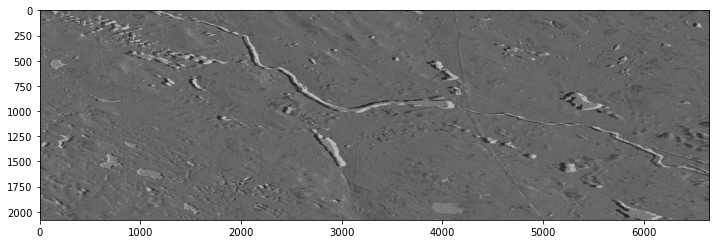

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
img_show =((lee_filter(fire_23_vh,3)**4)-(lee_filter(pre_fire_vh,3)**4))
axes.imshow(img_show,cmap='binary')
plt.show()

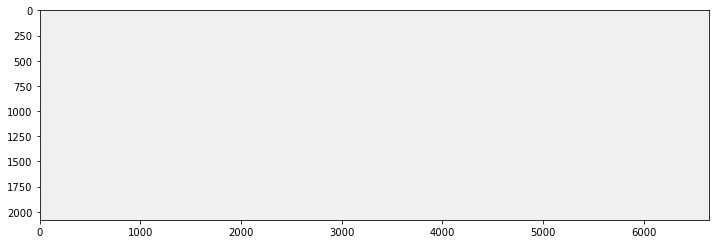

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
img_show =(fire_23_vh)/(pre_fire_vh)
axes.imshow(img_show,cmap='binary')
plt.show()

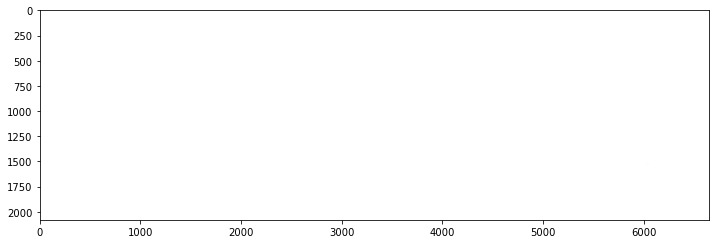

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axes.imshow((fire_23_vh**2/images[0]**2),cmap='binary')
plt.show()

# small subset


In [40]:
box_1_average_vh = np.average(np.dstack((images[0][1100:1200,3100:3200],images[2][1100:1200,3100:3200],images[4][1100:1200,3100:3200])), axis=-1)
box_2_average_vh = np.average(np.dstack((images[0][400:500,5400:5500],images[2][400:500,5400:5500],images[4][400:500,5400:5500])), axis=-1)
box_3_average_vh = np.average(np.dstack((images[0][650:750,4400:4500],images[2][650:750,4400:4500],images[4][650:750,4400:4500])), axis=-1)
box_4_average_vh = np.average(np.dstack((images[0][950:1050,1200:1300],images[2][950:1050,1200:1300],images[4][950:1050,1200:1300])), axis=-1)
box_5_average_vh = np.average(np.dstack((images[0][1000:1100,3400:3500],images[2][1000:1100,3400:3500],images[4][1000:1100,3400:3500])), axis=-1)
box_6_average_vh = np.average(np.dstack((images[0][1650:1750,800:900],images[2][1650:1750,800:900],images[4][1650:1750,800:900])), axis=-1)

box_1_average_vv = np.average(np.dstack((images[1][1100:1200,3100:3200],images[2][1100:1200,3100:3200],images[4][1100:1200,3100:3200])), axis=-1)
box_2_average_vv = np.average(np.dstack((images[1][400:500,5400:5500],images[2][400:500,5400:5500],images[4][400:500,5400:5500])), axis=-1)
box_3_average_vv = np.average(np.dstack((images[1][650:750,4400:4500],images[2][650:750,4400:4500],images[4][650:750,4400:4500])), axis=-1)
box_4_average_vv = np.average(np.dstack((images[1][950:1050,1200:1300],images[2][950:1050,1200:1300],images[4][950:1050,1200:1300])), axis=-1)
box_5_average_vv = np.average(np.dstack((images[1][1000:1100,3400:3500],images[2][1000:1100,3400:3500],images[4][1000:1100,3400:3500])), axis=-1)
box_6_average_vv = np.average(np.dstack((images[1][1650:1750,800:900],images[2][1650:1750,800:900],images[4][1650:1750,800:900])), axis=-1)

#Making the boxes into images...
fire_1_area_vh = images_17[1][1100:1200,3100:3200]
fire_2_area_vh = images_17[1][1000:1100,3400:3500]
fire_1_area_vv = images_17[3][1100:1200,3100:3200]
fire_2_area_vv = images_17[3][1000:1100,3400:3500]
no_fire_1_area_vh = images_17[1][400:500,5400:5500]
no_fire_2_area_vh= images_17[1][650:750,4400:4500]
no_fire_3_area_vh = images_17[1][950:1050,1200:1300]
no_fire_4_area_vh = images_17[1][1650:1750,800:900]
no_fire_1_area_vv = images_17[3][400:500,5400:5500]
no_fire_2_area_vv= images_17[3][650:750,4400:4500]
no_fire_3_area_vv = images_17[3][950:1050,1200:1300]
no_fire_4_area_vv = images_17[3][1650:1750,800:900]


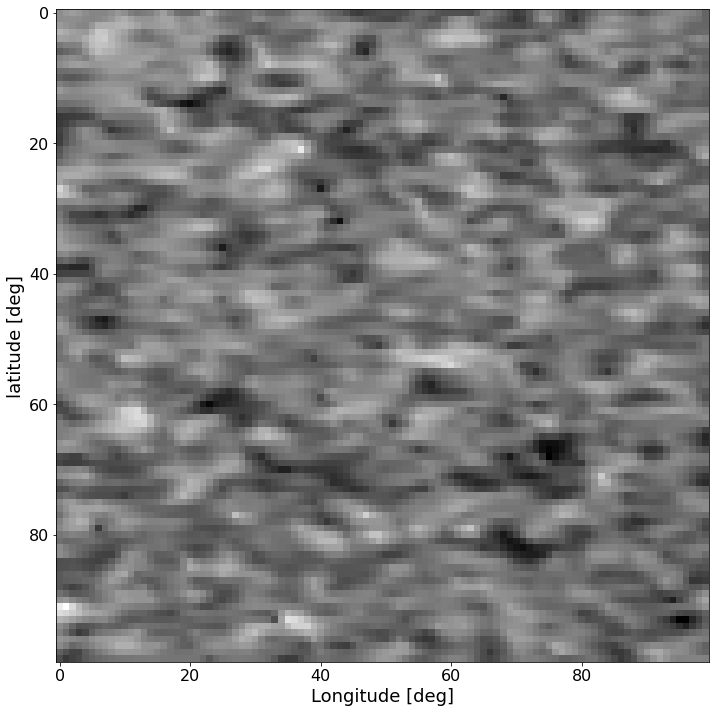

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axes.imshow(box_1_average-fire_1_area_vh,cmap='binary')
plt.xlabel('Longitude [deg]', fontsize=18)
plt.ylabel('latitude [deg]', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()